# Intro / Goals / Context


## Goal: 

Predict the fare of taxi tours

Is this a meaningful goal, or some placeholder task to do something?

## Question to Public:

" What kind of feature do you think necessary to have?"

" Why is this a datascience question?"

  - Uncertainty about the driver


# Motivation for the workshop?


What makes spatial data special? 
What kind of novel problems we face by working with spatial data?

    
    * COMPUTING DISTANCES: understand the spatial data properties (e.g. lat/lon, geodesical view)
    
    * being able to VISUALISE these datasets
        * plot heat maps on geographical backgrounds
        
    * ROUNDING must respect the architecture of the city, roads and building (example: route tracing should turn around the buildings).
    
    
    
# Modelling

## Get data and make exploratory plots to clean it.

* Use Kepler on cleaned data and develop a nice intuition.

## Baseline Model 00 (SO + CM)

* Do we use a mean/median value predictor as baseline?
* Explain Euclidean distance
* predict fare using the Euclidean distance
    Fare ~ 1 + EuclideanDistance
* Discuss what is the problem with the Euclidean distance.
    * TEACHING: Different types of distances
    * Have function definitions for different types of distances, explain code.
* Run the same model with different types of distances, and evaluate how much better the model becomes...
    Fare ~ 1 + X_Distance
    
## Updated Model 01 (EJ)

* use H3 hexagones as categorical features with the idea of capturing systematic variations in locations e.g. center of the city being more busy in general in comparison to a tour along the periphery of the city.


* demand within an hexagon.


## Updated Model 02 

* Daily seasonality: hour of the day as a feature with the idea 
    
    
## Updated Model 03 (CM)

Use https://osmcode.org/pyosmium/ to get route features.

* Get features from the route between pickup and dropoff
  ** # of traffic lights
  ** Allowed speed limit
  ** Number of lanes
  ** Number of hard lefts


## DISCUSSION

how to incorporate traffic information?


# (QUESTIONS for us) /

* do we want to train the model on all train data: Memory considerations


* Why is this task meaningful? 
    ** A simple rule is generating these data, why do we need data science to recover a known rule?
    
    ** how is what we want to do different than applying the rule that generates taxi fares?
    
    
* Are we going to train the model on the fly? If so, how long does it to fit it to 50 millions data points.


    

In [1]:
# TODO: Create pipenv and dockerfile for reproducibility

In [2]:
# %pip install pyproj # used to project lat longs to UTM and be able to use euclidean distances such as manhattan

In [3]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import keplergl
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from geopandas import GeoSeries, GeoDataFrame
from sklearn.neighbors import KNeighborsRegressor

from utils.OSRMFramework import OSRMFramework
from utils.RouteAnnotator import RouteAnnotator
from utils.lines import plot_linestring
from utils.conversor import latlon2linestring

%load_ext autoreload
%autoreload 2

###### constants
TARGET = 'fare_amount'
OSRM_PATH = 'localhost:5000'
dataset_path = 'data/sample_100000.csv'



In [4]:
# df = pd.read_csv('https://raw.githubusercontent.com/caiomiyashiro/geospatial_data_analysis/master/data/sample_100000.csv')
df = pd.read_csv(dataset_path)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
display(df.head())
display(df.dtypes)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.1,2009-01-23 07:28:00,-73.996070,40.732605,-73.980675,40.761864,1
1,9.0,2014-01-04 21:11:00,-73.977640,40.752346,-73.970390,40.768867,2
2,6.5,2015-06-22 01:54:24,-74.000080,40.728610,-73.988730,40.722170,6
3,4.5,2010-11-24 12:46:52,-73.962685,40.775646,-73.957436,40.777767,1
4,4.5,2011-11-01 02:19:34,-73.996300,40.753600,-73.998800,40.761100,1


fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

# First Analysis

## check amount of NaN - just remove them

In [6]:
# check amount of NaN - just remove them
display(df.drop('pickup_datetime',axis=1).apply(lambda col: np.sum(np.isnan(col)), axis=0))

df = df.loc[(~np.isnan(df['dropoff_latitude'])) & ~np.isnan(df['dropoff_longitude'])]

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
dtype: int64

## Check pickup points

In [7]:
# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
#                      'dropoff_latitude', 'dropoff_longitude']], name='points')
# w1

In [8]:
def remove_outside_bbox(df, bbox, lat_col, lon_col):
    df_ = df.copy()
    mask_lat = (df_[lat_col] > bbox[0][0]) & (df_[lat_col] < bbox[1][0])
    mask_lon = (df_[lon_col] > bbox[0][1]) & (df_[lon_col] < bbox[1][1])
    return df_.loc[(mask_lat) & (mask_lon)]

bottom_left_lat_lon = [40.492016, -74.279034]
upper_right_lat_lon = [40.913473, -73.689152]
bbox = [bottom_left_lat_lon, upper_right_lat_lon]

df = remove_outside_bbox(df, bbox, 'pickup_latitude', 'pickup_longitude')
df = remove_outside_bbox(df, bbox, 'dropoff_latitude', 'dropoff_longitude')

# w1 = keplergl.KeplerGl(height=500)
# w1.add_data(data=df[['pickup_latitude', 'pickup_longitude',
#                      'dropoff_latitude', 'dropoff_longitude']], name='points')
# w1

## Check impossible fares

Note that we're removing only impossible fares for now. Any filter based on value distribution should be done only using the training set.

In [9]:
display(df['fare_amount'].describe())
print('')

fare_under_0 = np.sum(df['fare_amount']<0)
print(f'{fare_under_0} rows with fare under 0')

df = df.loc[df['fare_amount'] >= 0]

count    97734.000000
mean        11.243156
std          9.432648
min        -10.100000
25%          6.000000
50%          8.500000
75%         12.500000
max        500.000000
Name: fare_amount, dtype: float64


8 rows with fare under 0


# Split training and testing before analysis

In [10]:
def split_training_test(df, target=TARGET, test_size=0.2):
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    return train_test_split(X, y, test_size=test_size, random_state=0) 

def join_Xy(df, target, target_str=TARGET):
    df_ = df.copy()
    df_[target_str] = target
    return df_

def get_initial_training_testing_set(df):
    X_train, X_test, y_train, y_test = split_training_test(df)
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape X_test {X_test.shape}')

    # join target for easier exploratory analysis
    df_train = join_Xy(X_train, y_train)
    df_test = join_Xy(X_test, y_test)
    return df_train, df_test

df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (78180, 6)
Shape X_test (19546, 6)


# Data Analysis

Only training data that will be used for training

## Remove fares < minimum fare and outliers > 99th percentile

In [11]:
# minimum fare: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

display(df_train['fare_amount'].describe(percentiles=[.01, .05, .1, .90,.95,.99]))
df_train = df_train.loc[(df_train['fare_amount'] > 2.5) & (df_train['fare_amount'] < 52)]


count    78180.000000
mean        11.245007
std          9.485479
min          0.000000
1%           3.300000
5%           4.100000
10%          4.500000
50%          8.500000
90%         20.000000
95%         30.000000
99%         52.000000
max        500.000000
Name: fare_amount, dtype: float64

## Average demand per region over 1 weekday - H3

In [12]:
# TODO

## Average Origin-Destination map over 1 weekday - H3

In [13]:
# TODO

# Model 00 - Euclidean Distance

## Start experiment tracking

In [14]:
iteration_results = {}

In [15]:
def euclidean_distance(x1, y1, x2, y2):
    return (((x2-x1)**2 + (y2-y1)**2)**(1/2))

df_train_temp = df_train.head(3).copy()
# Show how unrealistic it is, IF it's unrealisic
df_train_temp['euclidean_dist'] = euclidean_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,euclidean_dist
81127,2015-04-05 14:04:06,-73.978530,40.764107,-73.976875,40.751816,1,10.5,162.260732
88083,2009-10-22 20:28:40,-73.951350,40.778564,-73.963455,40.761920,2,5.7,162.249391
40667,2013-09-24 11:22:00,-74.012955,40.709984,-73.989600,40.702730,1,13.0,162.221094


In [16]:
def standardize_features(df):
    df_copy = df.copy()
    col_names = df_copy.columns
    ixs = df_copy.index
    return pd.DataFrame(StandardScaler().fit_transform(df_copy), columns=col_names, index=ixs)

def pre_processing_pipeline_1(df, target_col=TARGET,
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
  
    EUCLIDEAN_FEAT = 'euclidean_dist'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                                 df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_1= pre_processing_pipeline_1(df_train)
df_test_1 = pre_processing_pipeline_1(df_test)



In [17]:
model_1 = LinearRegression()
model_1.fit(df_train_1.drop(TARGET, axis=1), df_train_1[TARGET])

y_test_pred_1 = model_1.predict(df_test_1.drop(TARGET, axis=1))

RMSE: 7.888234959501506


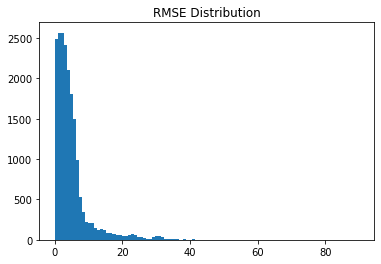

In [18]:
def print_evaluation(y_obs, y_pred, max_lim_y=100, return_errors=True):
    rmse_hist = np.sqrt((y_pred - y_obs)**2)
    plt.hist(rmse_hist[y_obs < max_lim_y], bins=100)
    plt.title('RMSE Distribution');

    if(return_errors == True):
        return mae_hist

#####
rmse = np.sqrt(mean_squared_error(df_test_1[TARGET], y_test_pred_1))
iteration_results['exp_1_rmse'] = rmse
print(f'RMSE: {rmse}')

print_evaluation(df_test_1[TARGET], y_test_pred_1, return_errors=False)

## Experimenting on different types of distance
### Haversine - Explain
### Manhattan - Explain


In [19]:
def lat_longs2radians(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return lon1, lat1, lon2, lat2

def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# TODO: manhattan with lat lon has NOT worked - see attempt below
# def manhattan_distance(lon1, lat1, lon2, lat2):
#   lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
#   dlon = np.abs(lon2 - lon1)
#   dlat = np.abs(lat2 - lat1)
#   return dlon + dlat

df_train_temp = df_train.head(3).copy()
df_train_temp['haversine_dist'] = haversine_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
                                                   df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])


# df_train_temp['manhattan_dist'] = manhattan_distance(df_train_temp['pickup_latitude'], df_train_temp['dropoff_latitude'], 
#                                                    df_train_temp['pickup_longitude'], df_train_temp['dropoff_longitude'])

df_train_temp


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine_dist
81127,2015-04-05 14:04:06,-73.978530,40.764107,-73.976875,40.751816,1,10.5,1.372925
88083,2009-10-22 20:28:40,-73.951350,40.778564,-73.963455,40.761920,2,5.7,2.111571
40667,2013-09-24 11:22:00,-74.012955,40.709984,-73.989600,40.702730,1,13.0,2.126155


In [20]:
# trying to convert to UTM and use traditional euclidean space to calculate manhattan BUT IT DIDN'T WORK



# from pyproj import Proj, transform

# inProj = Proj(init='epsg:4326')  # lat lon
# outProj = Proj(init='epsg:3857') # UTM

# lat_pickup_utm, lon_pickup_utm = transform(inProj,outProj,df_train['pickup_latitude'].values, df_train['pickup_longitude'].values)
# lat_dropoff_utm, lon_dropoff_utm = transform(inProj,outProj,df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

# df_train['manhattan_dist'] = np_manhattan(np.array(lat_pickup_utm), np.array(lat_dropoff_utm), 
#                                           np.array(lon_pickup_utm), np.array(lon_dropoff_utm))

In [21]:
def pre_processing_pipeline_2(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    FEATURES = [EUCLIDEAN_FEAT, HAVERSINE_FEAT] #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])

    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train_2 = pre_processing_pipeline_2(df_train)
df_test_2 = pre_processing_pipeline_2(df_test)


In [22]:
model_2 = LinearRegression()
model_2.fit(df_train_2.drop(TARGET, axis=1), df_train_2[TARGET])

y_test_pred_2 = model_2.predict(df_test_2.drop(TARGET, axis=1))

RMSE Error: 4.619993828905394


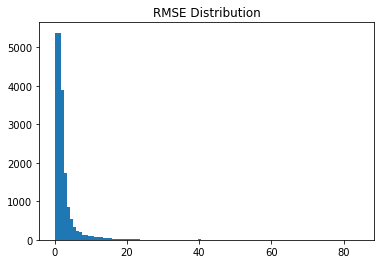

In [23]:
rmse_2 = np.sqrt(mean_squared_error(df_test_2[TARGET], y_test_pred_2))
iteration_results['exp_2_rmse'] = rmse_2
print(f'RMSE Error: {rmse_2}')

print_evaluation(df_test_2[TARGET], y_test_pred_2, return_errors=False)

In [24]:
iteration_results

{'exp_1_rmse': 7.888234959501506, 'exp_2_rmse': 4.619993828905394}

# Creating a router - OSRM Router

## Setup

Setting local docker image for ORSM back-end - https://hub.docker.com/r/osrm/osrm-backend/  
Commands explanation - https://github.com/Project-OSRM/osrm-backend/wiki/Running-OSRM#quickstart

* Paper on Multilevel Dijkstra - https://i11www.iti.kit.edu/_media/teaching/theses/ba-hamme-13.pdf  
* Introduction to Contraction Hierarchies -  https://movingai.com/IJCAI18-HS/ijcai-hs-harabor.pdf
  
Instructions:   

<div class="alert alert-block alert-info">     
    
* wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf (file is ~200 Mb)

* Move file to your project folder

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf
</div>    


Example latitude longitude New York: `-73.996070,40.732605;-73.980675,40.761864`

Test: `curl "http://localhost:5000/route/v1/driving/-73.996070,40.732605;-73.980675,40.761864?steps=false&geometries=geojson&annotations=true&overview=full"`

## Calculate street distances and durations

In [25]:
lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

osm = OSRMFramework('localhost:5000')
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

In [26]:
def get_route(osm, lat1, lon1, lat2, lon2):
    lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)
    return_col_names = ['route', 'distance_m', 'duration_sec', 'node_ids']
    if(type(lat) == float):
        return pd.Series([np.nan] * len(return_col_names), index=return_col_names)
    else:
        return pd.Series([latlon2linestring(lat, lon), distance, duration, node_ids], index=return_col_names)

routes = df_train.head().apply(lambda row: get_route(osm, 
                                            row['pickup_latitude'],
                                            row['pickup_longitude'],
                                            row['dropoff_latitude'],
                                            row['dropoff_longitude']), axis=1)
routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)

routes

,route,distance_m,duration_sec,node_ids
81127,"LINESTRING (-73.97853000000001 40.764107, -73....",2235.5,207.0,"[4544486781, 42430378, 42430384, 6654368342, 4..."
88083,"LINESTRING (-73.95135000000001 40.778564, -73....",2849.2,300.7,"[42443040, 42450030, 42447136, 42429334, 54025..."
40667,LINESTRING (-74.01295500000001 40.709984000000...,3532.1,399.0,"[42434412, 42434413, 5487737822, 42436192, 150..."
69985,"LINESTRING (-73.97279 40.758907, -73.972846 40...",8963.1,694.2,"[3977886228, 596775914, 596775876, 3977886201,..."
22252,"LINESTRING (-73.98543000000001 40.740368, -73....",2935.9,327.5,"[42436578, 42436582, 4115878741, 42436586, 411..."


In [27]:
# TEMP: because router take too much time, I've saved the routes from this sample here. If you want to
# use the router anyway, comment lines where pickle is read and uncomment commented lines

# TEMP files are saved on GDrive for now: 
# https://drive.google.com/file/d/1wQI18n982C0QmeH2iJWVxQbxoHuddktM/view?usp=sharing

def pre_processing_pipeline_3(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              osm_router=OSRM_PATH,
                              test_mode=None):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    ROUTE_DISTANCE = 'route_distance_meters'
    ROUTE_DURATION = 'route_duration_seconds'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                HAVERSINE_FEAT, #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong
                ROUTE_DISTANCE,
                ROUTE_DURATION] 

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])
    
    if(test_mode == 'train'):                                                          # TEST MODE
        with open('data/temp_routes_train.pickle', 'rb') as f:                         # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE
    elif(test_mode == 'test'):                                                         # TEST MODE
        with open('data/temp_routes_test.pickle', 'rb') as f:                          # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE   
        
#     routes = df_copy.apply(lambda row: get_route(osm, 
#                                             row['pickup_latitude'],
#                                             row['pickup_longitude'],
#                                             row['dropoff_latitude'],
#                                             row['dropoff_longitude']), axis=1)
#     routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']
    df_copy[ROUTE_DURATION] = routes['duration_sec']
    
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res, routes

df_train_3, routes_train = pre_processing_pipeline_3(df_train, test_mode='train')
df_test_3, routes_test = pre_processing_pipeline_3(df_test, test_mode='test')


##### Save locally when executting OSRM
# with open('data/temp_routes_train.pickle', 'wb') as f:
#     pickle.dump(routes_train, f)
    
# with open('data/temp_routes_test.pickle', 'wb') as f:
#     pickle.dump(routes_test, f)

In [28]:
model_3 = LinearRegression()
model_3.fit(df_train_3.drop(TARGET, axis=1), df_train_3[TARGET])
y_test_pred_3 = model_3.predict(df_test_3.drop(TARGET, axis=1))


RMSE Error: 4.482986798905145


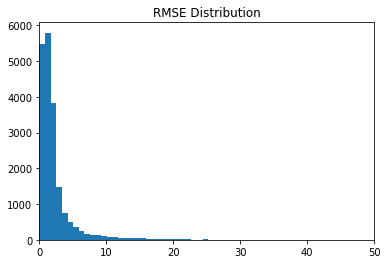

In [29]:
#####
rmse_3 = np.sqrt(mean_squared_error(df_test_3[TARGET], y_test_pred_3))
iteration_results['exp_3_rmse'] = rmse_3
print(f'RMSE Error: {rmse_3}')

print_evaluation(df_test_3[TARGET], y_test_pred_3, return_errors=False)
plt.xlim([0, 50]);

In [30]:
iteration_results

{'exp_1_rmse': 7.888234959501506,
 'exp_2_rmse': 4.619993828905394,
 'exp_3_rmse': 4.482986798905145}

# 2nd Exploratory Analysis

## Check why we have some route distance == 0

In [31]:
df_train_3_analysis = df_train_3.merge(df_train, how='left', left_index=True, right_index=True)

df_train_3_analysis['route_distance_km'] = routes_train['distance_m']/1000
display(df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head()) # PROBLEM pickup == dropoff

##########################################################
### Filter where pick up and drop off are the same
##########################################################


,euclidean_dist,haversine_dist,route_distance_meters,route_duration_seconds,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,route_distance_km
59542,-1.880573,-1.004338,-1.002788,-0.515215,5.0,2013-06-04 10:05:50,-73.901955,40.76404,-73.901955,40.76404,1,5.0,0.0
38815,-0.053800,-1.004338,-1.002788,-0.515215,7.5,2012-10-26 22:26:00,-73.989100,40.73636,-73.989100,40.73636,1,7.5,0.0
51352,-0.971902,-1.004338,-1.002788,-0.515215,27.3,2012-03-30 12:01:00,-73.937454,40.75812,-73.937454,40.75812,1,27.3,0.0
68537,-2.251518,-1.004338,-1.002788,-0.515215,9.3,2011-10-27 20:01:19,-73.870820,40.78310,-73.870820,40.78310,1,9.3,0.0
75880,2.317333,-0.840664,-1.002788,-0.515215,45.0,2014-11-22 01:06:00,-74.061500,40.73936,-74.060530,40.74390,1,45.0,0.0


## Some leftover routes still have route_distance == 0, investigate

In [32]:
df_train_3_analysis = df_train_3_analysis.loc[df_train.index].copy()

df_train_3_analysis['distances'] = haversine_distance(df_train_3_analysis['pickup_latitude'], df_train_3_analysis['dropoff_latitude'],
                               df_train_3_analysis['pickup_longitude'], df_train_3_analysis['dropoff_longitude'])

df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] == 0].head() ### ?? - ~65 examples

##########################################################
### Filter where route_distance == 0 for next iteration###
##########################################################


,euclidean_dist,haversine_dist,route_distance_meters,route_duration_seconds,fare_amount_x,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_y,route_distance_km,distances
59542,-1.880573,-1.004338,-1.002788,-0.515215,5.0,2013-06-04 10:05:50,-73.901955,40.76404,-73.901955,40.76404,1,5.0,0.0,0.000000
38815,-0.053800,-1.004338,-1.002788,-0.515215,7.5,2012-10-26 22:26:00,-73.989100,40.73636,-73.989100,40.73636,1,7.5,0.0,0.000000
51352,-0.971902,-1.004338,-1.002788,-0.515215,27.3,2012-03-30 12:01:00,-73.937454,40.75812,-73.937454,40.75812,1,27.3,0.0,0.000000
68537,-2.251518,-1.004338,-1.002788,-0.515215,9.3,2011-10-27 20:01:19,-73.870820,40.78310,-73.870820,40.78310,1,9.3,0.0,0.000000
75880,2.317333,-0.840664,-1.002788,-0.515215,45.0,2014-11-22 01:06:00,-74.061500,40.73936,-74.060530,40.74390,1,45.0,0.0,0.511076


## Check price per kilometer

In [33]:
temp = df_train_3_analysis.loc[df_train_3_analysis['route_distance_km'] != 0]

price_km = temp['fare_amount_y']/temp['route_distance_km']
display(price_km.describe(percentiles=[.9, .95, .99]))

##########################################################
### Filter where price per km > 5 - 95th percentile    ###
##########################################################

count     76317.000000
mean         58.028857
std        4080.245475
min           0.165007
50%           2.854109
90%           4.810838
95%           5.858411
99%          11.065728
max      498000.000000
dtype: float64

# Embed taxi rules - https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

In [34]:
# TODO: Investigate

# Embed Nearest neighboors fares

1st Geography Law: https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography

"everything is related to everything else, but near things are more related than distant things."

In [35]:
# TODO: Show small example as previous pipelines

In [36]:
%%time

def pre_processing_pipeline_4(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude',
                              pickup_datetime_col='pickup_datetime',
                              osm_router=OSRM_PATH,
                              nn_avg_fare_model=None,
                              test_mode=None):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    ROUTE_DISTANCE = 'route_distance_meters'
    ROUTE_DURATION = 'route_duration_seconds'
    NN_AVG_FARE = 'nn_avg_fare'
    
    FEATURES = [EUCLIDEAN_FEAT, 
                HAVERSINE_FEAT, #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong
                ROUTE_DISTANCE,
                ROUTE_DURATION,
                NN_AVG_FARE] 

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])
    
    if(test_mode == 'train'):                                                          # TEST MODE
        with open('data/temp_routes_train.pickle', 'rb') as f:                         # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE
    elif(test_mode == 'test'):                                                         # TEST MODE
        with open('data/temp_routes_test.pickle', 'rb') as f:                          # TEST MODE
            routes = pickle.load(f)                                                    # TEST MODE   
        
#     routes = df_copy.apply(lambda row: get_route(osm, 
#                                             row['pickup_latitude'],
#                                             row['pickup_longitude'],
#                                             row['dropoff_latitude'],
#                                             row['dropoff_longitude']), axis=1)

#     routes['route'] = GeoSeries([elem[0] if type(elem) == GeoSeries else np.nan for elem in routes['route']], index=routes.index)
    df_copy[ROUTE_DISTANCE] = routes['distance_m']
    df_copy[ROUTE_DURATION] = routes['duration_sec']
    
    ###### Outliers Filtering
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()
    
    df_copy = df_copy.loc[df_copy[ROUTE_DISTANCE] != 0].copy()
    
    price_per_km = df_copy[target_col]/(df_copy[ROUTE_DISTANCE]/1000)
    df_copy = df_copy.loc[price_per_km < 5].copy()
    ######
    
    ###### prepare for NN avg fare model
    minutes_since_monday_midnight = 'minutes_since_monday_midnight'
    df_copy[minutes_since_monday_midnight] = df_copy[pickup_datetime_col].dt.dayofweek * (24*60) + \
                                               df_copy[pickup_datetime_col].dt.hour * 60 + \
                                               df_copy[pickup_datetime_col].dt.minute
    
    
    nn_features = [pickup_latitude, pickup_longitude, 
                       dropoff_latitude, dropoff_longitude, 
                       minutes_since_monday_midnight]
    nn_data = standardize_features(df_copy[nn_features])
    nn_data[target_col] = df_copy[target_col]
    if(test_mode == 'train'):
        nn_avg_fare_model = KNeighborsRegressor(n_neighbors=10)
        nn_avg_fare_model.fit(nn_data.drop(target_col, axis=1), nn_data[target_col])
    df_copy[NN_AVG_FARE] = nn_avg_fare_model.predict(nn_data.drop(target_col, axis=1))  
    ######
    
    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    
    return df_res, routes, nn_avg_fare_model

df_train_4, routes_train, nn_avg_fare_model = pre_processing_pipeline_4(df_train, test_mode='train')
df_test_4, routes_test, nn_avg_fare_model = pre_processing_pipeline_4(df_test, test_mode='test', nn_avg_fare_model=nn_avg_fare_model)


CPU times: user 5.78 s, sys: 669 ms, total: 6.45 s
Wall time: 6.53 s


In [37]:
model_4 = LinearRegression()
model_4.fit(df_train_4.drop(TARGET, axis=1), df_train_4[TARGET])
y_test_pred_4 = model_4.predict(df_test_4.drop(TARGET, axis=1))


RMSE Error: 3.474212045918078


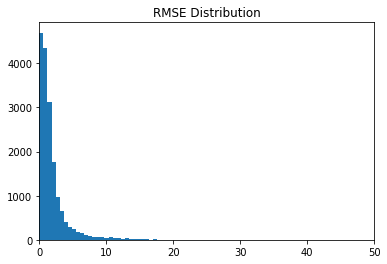

In [38]:
#####
rmse_4 = np.sqrt(mean_squared_error(df_test_4[TARGET], y_test_pred_4))
iteration_results['exp_4_rmse'] = rmse_4
print(f'RMSE Error: {rmse_4}')

print_evaluation(df_test_4[TARGET], y_test_pred_4, return_errors=False)
plt.xlim([0, 50]);

In [39]:
iteration_results

{'exp_1_rmse': 7.888234959501506,
 'exp_2_rmse': 4.619993828905394,
 'exp_3_rmse': 4.482986798905145,
 'exp_4_rmse': 3.474212045918078}

# Time to search 10 NN = Expensive

## Explain Spatial Indices KDTree - Parameters from KNNRegressor - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

## Possible use ANNOY - https://github.com/spotify/annoy

In [40]:
# TODO: Decide and maybe use annoy already in pipeline 4 V2.

# One last iteration? Don't do it if we embed taxi rules and it somehow improves it in previous section

In [41]:
# TODO: Think on one last iteration

# Traffic Prototype

<img src="images/traffic.png" width="500"> 
<center>Traffic information from Google Maps</center>

As you've learned already, OSRM works over partitioning OSM's data into a routable graph. OSRM works great if you want the **shortest** route, *i.e.*, find the minimum path between two nodes where the edge weight is the street length. However, if you want to consider more realistic scenarios, OSRM provide you with tools to route the **fastest** route between two nodes, *i.e.*, incorporate your own traffic data inside the router so it takes this information into consideration ([Reference](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic)). Before we dig into the traffic data incorporation, lets first take a look at how OSM maps data internally:  

## OSM Data Types

### Nodes, Ways and Relations  

<img src="images/osm_data_types_.jpg" width="500"> 
<center>Data types in OSM</center>  

Everything that is inside OSM is represent by one of three possible geometries ([Reference](https://labs.mapbox.com/mapping/osm-data-model/)):
* **Node** - A node is everything that can be represented by a point, a unique object with no large spatial dimensions, such as a POIs or objects, such as this lamp post: https://www.openstreetmap.org/node/6343276469  
* **Way** - A way is a line connecting two or more nodes. In this workshop's use case, ways are mainly streets connecting two nodes, *i.e.*, street intersections. Example: https://www.openstreetmap.org/way/4402228
* **Relations** - As the name says, relations are used to create higher level structures that contains nodes and ways inside it. Example: https://www.openstreetmap.org/relation/1685018  

### Tags
  
Tags are the metadata of each data type defined above. All data types contains a set of possible (but not mandatory) tags related to the tags' semantics. For instance, if you look at the left side of the screen in any of the data types examples above, you'll see that:  
* **Nodes** have a description of what exactly is the node. Implicitly, **all** OSM nodes also have a `latitude/longitude` associated with it.
* Street **Ways** have informations about the street, such as whether it has a `bicycle path`, if it has a `sidewalk` and mainly, what is it's `maximum driving speed`. An important observation on ways is that **it doesn't always have maximum speed**. Ways in OSM were not created having routing in mind so that ways can be defined split in multiple pieces or a same path can be inside different ways. See for example https://www.openstreetmap.org/way/7552152 and https://www.openstreetmap.org/way/48859717. Street ways can also be complex because we might not have the same street speed during the whole 
* An important feature about **Relations** is their [administrative level](https://wiki.openstreetmap.org/wiki/Key:admin%20level?uselang=en-GB). This level indicates the level of hierarchy that this relation is taking in terms of spatial boundary. Small administrative levels indicate small spaces, such as parks and neighbors while higher administrative levels go to cities/countries/continents.
  
## Traffic Proof of Concept (POC)

OSRM allows you to define what is the street speed by allowing you to provide an external CSV file that sets it. For that, you need to define the speeds segment by segment, *i.e.*, by each pair of sequential node ids, you can set what is the street speed at that point ([Reference](https://github.com/Project-OSRM/osrm-backend/wiki/Traffic)).  
  
Lets learn how to use for a simple example. 
1. When we call the router we used in the sections above, it also returns the sequence of node ids that compose the route in OSM. 
2.  We take the same example of pick up and drop off as above, but then we're going to set all street speeds between those segments to 1 (km/h).  
3. We're then going to set up the router with the new "traffic" information and see what happens
  
<div class="alert alert-block alert-info"> 
<b>Be careful</b>: Do <b>not</b> set the speeds to 0, as it breaks the router by unkown reasons, until now.    
</div>


In [42]:
# redo route command with previous router

lat1, lon1 = 40.732605,-73.996070
lat2, lon2 = 40.761864,-73.980675

lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

The command above returned a list of node ids that compose the route. We're now going to run a loop over these node ids and create a dataframe (and then a csv) containing the node pairs and the new street speed

### For each segment between 2 nodes, set speed to lowest possible = 1 km/h. `NOT 0`

In [43]:
node_from = []
node_to = []
node_speed = []
i = 1
while i < len(node_ids):
    node_from.append(node_ids[i-1])
    node_to.append(node_ids[i])    
    node_speed.append(1)
    i += 1
blocked = pd.DataFrame({'node_from': node_from, 'node_to': node_to, 'node_speed': node_speed})

# Save file with segment speeds with no columns headers nor row indexes
blocked.to_csv('router/test_traffic.csv', header=False, index=False)

### Reset router updating street speeds informations

The procedure here is the same as the previous router set up. The `only difference is the new parameter in osrm-customize` 
  
--> `--segment-speed-file /data/traffic_file.csv`. 

<div class="alert alert-block alert-info">  
    
* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf `--segment-speed-file /data/test_traffic.csv`

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf  
</div>
  
### Call router again and check new route

With the new router set up, we can calculate the route for the same pick-up/drop-off points as before and see how it's changed. We can see that the router avoids as best as possible to stay away from the segments we marked as heavy traffic, *i.e.*, segment speed = 1 km/h.

In [43]:
lat, lon, distance, duration, node_ids = osm.route(lat1, lon1, lat2, lon2)

t = latlon2linestring(lat, lon)

plot_linestring(t)

## Match noisy GPS to Node IDs

The POC works fine if you have the node id's for all your route points, which unfortunately, isn't the case.  
Besides:  

- GPS sampling might be not stable, *e.g.*, some times we have sampling of 5 secs, other times 10 secs.
- Points might not fall exactly on the street due to GPS inaccuracy

So, lets recreate a possible real world GPS trace by taking a trace returned by the router in section [Embed Nearest neighboors fares](#Embed-Nearest-neighboors-fares) and disturb it: 

In [44]:
lines = df_train.merge(routes_train, how='left', left_index=True, right_index=True)
trace = lines['route'].iloc[30]

lon, lat = trace.xy[0], trace.xy[1]

lat, lon = np.delete(lat, -3),  np.delete(lon, -3)         # cut corner at the bottom part
np.random.seed(42)                                       # choose 10 random points to disturb
choices = np.random.choice(range(len(lat)), size=10, replace=False)
lat[choices] = lat[choices] + np.random.normal(0, 0.001) # add noise 
lon[choices] = lon[choices] + np.random.normal(0, 0.001) # add noise

t = latlon2linestring(lat, lon)

plot_linestring(t)

We can see that some of the points don't even fall on a street segment and, like in the route close to the bottom-right side, a node indicating a turn is missing in a way that, when we connect the nodes with a line, the line goes through the building blocks.  
  
As we know that every node in OSM has a lat/lon associated with it, we could associate each trace point to the closest node. As Newson and Krumm showed ([Reference](https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf)):
* This is error prone, as this kind of approach in street condensed networks can match GPS points to unrelated street segments. 
* The approach doesn't take the previous and future GPS points in order to match a GPS point to the street, *i.e.*, if previous and next point are over a bridge, it's highly improbable that the current matched GPS point is outside the bridge, even if it's closer to a node outside the bridge.  
  
We can see this kind of examples in the picture below:  

<img src="images/map_matching_example.png" width="300"> 
<center>GPS matching potential errors - as in <a href="https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf">https://www.ismll.uni-hildesheim.de/lehre/semSpatial-10s/script/6.pdf</a></center> 

### Snap noisy GPS points to street using map matching 

Newson and Krumm created an approach that takes into account the whole sequence of nodes and then try to match them in a probabilistic way. The way they do this is by using a Hidden Markov Model (HMM), where the states are each of the nodes presented in the map and the observation sequences are the GPS location sequences. 
  
OSRM already provide it for us out of the box and we can use the OSRMFramework class to extract the main information using the router we have already set up.  
* API - http://project-osrm.org/docs/v5.5.1/api/#match-service  
  
Main parameters to be understood here are:  
* **geometries**: set of latitudes and longitudes that will be matched to the street.
* **timestamps**: set of **unix timestamps** where `len(timestamps) == len(geometries)`. Timestamps can be used as an additional information when matching points. The bigger the difference between two timestamps from two sequential GPS points are, the more loose we can be when matching them to the street.
* **radiuses**: set of **integers** where `len(radiuses) == len(geometries)`. When GPS points are obtained from sensors or, mainly, smartphones, each point comes with an accuracy measure associated with it. The number represents the uncertainty radius around each point, where the true position could be in any place inside the circle. The bigger the uncertainty, the more loose the points can be matched to the street, of course, also increasing the chances of a false matching.  

For a deeper look on how map matching works, please refer to the [#Appendix](#Appendix) section.  

Lets now take a look of how the disturbed street is after map matching:

In [45]:
# TODO: Explain basics of map matching in Appendix section. 
# If explaining HMM, copy from chord recognition project - 
# https://github.com/caiomiyashiro/music_and_science/blob/master/Chord%20Recognition/complete_pydata_hidden_markov_models_for_chord_recognition.ipynb


In [46]:
lat, lon, nodes_id = osm.match(lat, lon, timestamps=None, radiuses=None)

t = latlon2linestring(lat, lon)

plot_linestring(t)

## Traffic Data Processing

<img src="images/traffic_sequential.jpg" width="400"> 
<center>Trace accumulation per time window</center> 
  
So until now, we know how we can have multiple GPS points and their associated node ids and timestamps. However, `how do I turn them into traffic information?`  

The main source of information in the mobility context is [Floating Car Data](https://en.wikipedia.org/wiki/Floating_car_data). Nowadays, no one walk without a smartphone. These devices can locate their own position and send to appropriate services through a mobile internet connection. As the data arrive to the servers, they can be used in two ways to calculate traffic information:
* **Real time**: As soon as the data arrive, it can be binned/aggregated for a specific time window, *e.g.*, 10 minutes, and then used the extracted measures to update a traffic router.
* **Historical aggregates**: The influx of data can be stored for a longer time and we can process it in order to extract average traffic patterns over a certain period of time. For example, we could aggregate 1 month of data into 1 week of usual behavior and use this as traffic features for your router.  

You can check that these are the two options used by google here: https://www.google.com/maps/place/Nova+Iorque,+NY,+EUA/@40.6971494,-74.2598655,10z/data=!3m1!4b1!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728!5m1!1e1

Whether you're binning your data in real time bins or historical aggregates, conceptually, the procedure for the data processing for the traffic router data is the same.  




<div class="alert alert-block alert-info">  
The accessibility to public car's GPS traces is still rare. When companies have access to this kind of information, they usually don't make publicly available. In this traffic section we're working with a mock of GPS signals, made by OSRM itself to build routes from A to B. The objective of this part then is not to analyze data or summaries statistics, but to understand possible techniques on how to embed traffic information into your OSRM.
</div>

The goal of creating traffic data from historical aggregates is to bin your historic data into bins and then summarize the average metric present in multiple days into an average metric. The main source usually used is <b>speed</b>. However, in this mock data, as we don't have access to GPS speed information, we will use <i>count</i> as a proxy to traffic measures.   
  
Lets start with a set of GPS routes, pretending that they're our GPS set obtained by yourself or from a third-party company. After applying map-matching to then, we then end up with a list of node ids, as the [previous section](#Snap-noisy-GPS-points-to-street-using-map-matching) showed. For this example, I'll bin the samples in a hourly basis, but this kind be defined depending in your use case.

In [47]:
lines_k = lines.loc[lines['pickup_datetime'].dt.year == 2015][['pickup_datetime', 'node_ids']].copy()
lines_k['pickup_datetime'] = lines_k['pickup_datetime'].dt.strftime('%H:00:00')

display(lines_k.head(3))


,pickup_datetime,node_ids
81127,14:00:00,"[4544486781, 42430378, 42430384, 6654368342, 4..."
69985,11:00:00,"[3977886228, 596775914, 596775876, 3977886201,..."
18150,19:00:00,"[3639381190, 42459085, 100521730, 1690448972, ..."


The **objective** of the following code blocs is to convert the dataframe above into a a list line segments (2 node ids), the hour bin and how many times this segment appeared in this time bin, like the example below:

| datetime | count | segment linestring|
|------|------|------|
|   13:00  | 5 | LINESTRING (-73.9600437 40.7980478, -73.959547...|  

For that we need to:
1. Process every node id pair from every route, *i.e.*, the route's segments
2. Count how many times the segment occurred grouped by hour bin
3. Extract node's position (lat/lon) and convert segments to geometric formats  
 

In [48]:
# 1. Process every node id pair from every route, i.e., the route's segments 

from_node = []
to_node = []
seg_date = []
for ix, row in lines_k.iterrows():
    row_df = pd.DataFrame()
    lat_lon_pairs = []
    i = 1
    while i < len(row['node_ids']):
        from_node.append(row['node_ids'][i-1])
        to_node.append(row['node_ids'][i]) 
        seg_date.append(row['pickup_datetime'])
        i += 1

seg_df = pd.DataFrame({'seg_date': seg_date, 'from_node': from_node, 'to_node': to_node})
seg_df.head()

,seg_date,from_node,to_node
0,14:00:00,4544486781,42430378
1,14:00:00,42430378,42430384
2,14:00:00,42430384,6654368342
3,14:00:00,6654368342,42432818
4,14:00:00,42432818,42432825


In [49]:
# 2. Count how many times the segment occurred grouped by hour bin

def count_duplicates(group):
    group_res = group.groupby(['from_node', 'to_node']).size().reset_index().rename(columns={0:'records'})
    group_res['seg_date'] = group.name
    return group_res

group_res = seg_df.groupby('seg_date').apply(count_duplicates).reset_index(drop=True)
group_res.head()


,from_node,to_node,records,seg_date
0,42421728,42432736,1,00:00:00
1,42421728,4205830390,1,00:00:00
2,42421731,4205830392,1,00:00:00
3,42421737,42421741,1,00:00:00
4,42421741,42432756,1,00:00:00


Tasks 1 and 2 are straightforward, needing basically some processing. However, for task 3, we need to map our node ids to lat/lons and, unfortunately, **OSRM doesn't provide us with that information**, for optimization reasons. You check some issues in Github [here](https://github.com/Project-OSRM/osrm-backend/issues/5310) and [here](https://github.com/Project-OSRM/osrm-backend/issues/5490) and some more at their Github repository. Enter...[OSMNx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/).  

### Open Street Maps + NetworkX (OSMnx) and RouteAnnotator   

<img src="images/lausanne_.png" width="350"> 
<center>Lausanne's driving network</center>  

OSMnx is a framework that works over OSM data and has multiple ways to extract data about street networks, including, nodes, ways, relations and **all the tags associated with them**.  
  
The `RouteAnnotator` class access OSMnx, retrieve desired street network and extract all metadata related to nodes, ways and node segments (node pairs and nodes belonging to same way). For now, it can only extract a network based on [osmnx.graph_from_place](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_place) function but you can read more about other ways to retrieve data in OSMnx's documentation.  

RouteAnnotator creates three main functions similar to [Mapbox's route-annotator](https://github.com/mapbox/route-annotator) and in the future it will be used as a service, so you don't need to know python or programming in order to use it. Its main functions are:
* **segment_lookup** - provided a list of node ids with size $N$, it returns $N-1$ segments containing data such as the way_id that this segment belongs to
* **way_lookup** - provided a list of ways_id, it returns the metadata associated with all ways, including an ordered list of node_ids that compose that way
* **node_lookup** - provided a list of node_ids, it returns the metadata associated with all nodes, including latitude and longitude.  
  
We're going to use RouteAnnotator in order to retrieve the nodes' lat/lon and keep processing our traffic dataset:  

In [50]:
# download and process new york city street graph
ra = RouteAnnotator('new york, USA', 'drive_service')

In [51]:
# 3. Extract node's position (lat/lon) and convert segments to geometric formats

line_seg = []
for ix, row in group_res.iterrows():
    try:
        metadata1 = ra.node_lookup(row['from_node'])  # use RouteAnnotator to retrieve node's metadata
        m1_lat_lon = [metadata1['y'], metadata1['x']] # such as lat/lon
        metadata2 = ra.node_lookup(row['to_node'])
        m2_lat_lon = [metadata2['y'], metadata2['x']]
        line_segment = latlon2linestring(lat = [m1_lat_lon[0], m2_lat_lon[0]], 
                                         lon = [m1_lat_lon[1], m2_lat_lon[1]])[0]
        line_seg.append(line_segment)
    except Exception:
        line_seg.append(np.nan)
        continue
        

group_res = GeoDataFrame(group_res, geometry=line_seg)
group_res.head()

,from_node,to_node,records,seg_date,geometry
0,42421728,42432736,1,00:00:00,"LINESTRING (-73.9600437 40.7980478, -73.959547..."
1,42421728,4205830390,1,00:00:00,"LINESTRING (-73.9600437 40.7980478, -73.960424..."
2,42421731,4205830392,1,00:00:00,"LINESTRING (-73.96147430000001 40.798645, -73...."
3,42421737,42421741,1,00:00:00,"LINESTRING (-73.962886 40.7992545, -73.9657046..."
4,42421741,42432756,1,00:00:00,"LINESTRING (-73.9657046 40.8004313, -73.965207..."


Finally, we have the street segment and their respective "popularity", *i.e.*, count, aggregated by hour. In a real GPS database, the `records` columns would be replaced by the average speed of gps traces that passed through it. Lets visualize it!  

After finalizing the dataset above, we could save them as the first CSV file that we've saved containing our desired metric.

In [52]:
w1 = keplergl.KeplerGl(height=500)
w1.add_data(data=group_res[['seg_date', 'geometry', 'records']].dropna(), name='traces')
w1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'traces': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …